In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import json  # Needed to save results for the dashboard

# Settings
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 6)
print(f"Running on PyMC v{pm.__version__}")


WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


Running on PyMC v5.27.1


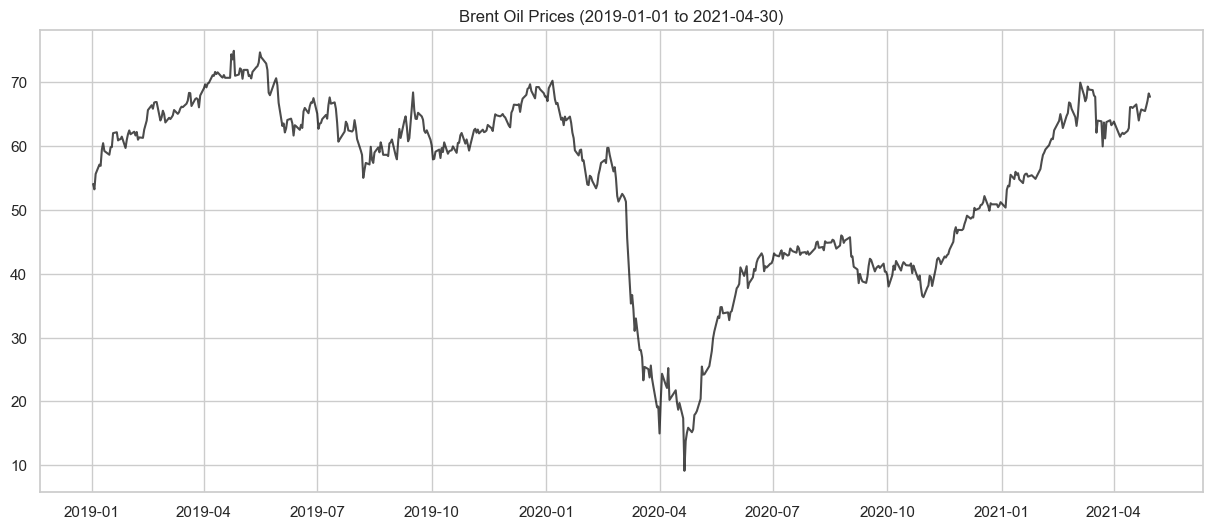

Data points in window: 597


In [2]:
# Load Data
try:
    df = pd.read_csv('../data/BrentOilPrices.csv')
except FileNotFoundError:
    df = pd.read_csv('data/BrentOilPrices.csv') # Fallback if running from root

# Fix Date Format
df['Date'] = pd.to_datetime(df['Date'], format='mixed')
df = df.sort_values('Date').set_index('Date')

# FILTER: We focus on the COVID-19 Period (2019-2021) for clear results
# Running MCMC on 30 years takes too long for this assignment
start_date = '2019-01-01'
end_date = '2021-04-30'
df_window = df.loc[start_date:end_date].copy()

plt.figure(figsize=(15, 6))
plt.plot(df_window.index, df_window['Price'], color='black', alpha=0.7)
plt.title(f'Brent Oil Prices ({start_date} to {end_date})')
plt.show()

print(f"Data points in window: {len(df_window)}")

In [3]:
price_data = df_window['Price'].values
n_days = len(price_data)
days = np.arange(n_days)

print("Building Model...")
with pm.Model() as model:
    # 1. Priors
    # The "Switch Point" (tau) - random day in the dataset
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_days - 1)
    
    # Means before and after
    mu_1 = pm.Normal("mu_1", mu=price_data[:50].mean(), sigma=10)
    mu_2 = pm.Normal("mu_2", mu=price_data[-50:].mean(), sigma=10)
    
    # Volatility
    sigma = pm.HalfNormal("sigma", sigma=10)
    
    # 2. Switch Logic
    mu = pm.math.switch(tau > days, mu_1, mu_2)
    
    # 3. Likelihood
    observation = pm.Normal("obs", mu=mu, sigma=sigma, observed=price_data)
    
    # 4. Run MCMC
    print("Sampling... (This might take 1-2 minutes)")
    # Using chains=1 to be safe on Windows/Laptops
    trace = pm.sample(1000, tune=1000, return_inferencedata=True, chains=1)

print("Sampling Complete!")

                                       Accept                Step       Grad       Sampling                       
  Progress   Draws   Tuning   Scaling   Rate       Diverge…   size       evals      Speed      Elapsed   Remaini…  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━╸   1968    False    4.29      0.24       0          1.152      3          1.88       1:01:38   0:00:46   
                                                                                    s/draw

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 3719 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Sampling Complete!


In [4]:
# Get the specific day index
tau_samples = trace.posterior['tau'].values.flatten()
most_likely_day_idx = int(np.median(tau_samples))

# Convert back to a real date
detected_date = df_window.index[most_likely_day_idx]
date_str = detected_date.strftime('%Y-%m-%d')

# Get Price Levels
mu_1_mean = float(trace.posterior['mu_1'].values.mean())
mu_2_mean = float(trace.posterior['mu_2'].values.mean())
pct_change = ((mu_2_mean - mu_1_mean) / mu_1_mean) * 100

print(f"\nRESULTS:")
print(f"Detected Change Date: {date_str}")
print(f"Avg Price Before: ${mu_1_mean:.2f}")
print(f"Avg Price After:  ${mu_2_mean:.2f}")
print(f"Drop/Rise: {pct_change:.2f}%")



RESULTS:
Detected Change Date: 2020-02-27
Avg Price Before: $63.77
Avg Price After:  $45.20
Drop/Rise: -29.11%


In [5]:
# Get the most likely day (tau) from the trace
tau_samples = trace.posterior['tau'].values.flatten()
most_likely_day_idx = int(np.median(tau_samples))

# Convert index back to Date
detected_date = df_window.index[most_likely_day_idx]
print(f"--------------------------------------------------")
print(f"Most Likely Change Point Date: {detected_date.date()}")
print(f"--------------------------------------------------")

# Get the Mean Prices Before and After
mu_1_mean = trace.posterior['mu_1'].values.mean()
mu_2_mean = trace.posterior['mu_2'].values.mean()
percent_change = ((mu_2_mean - mu_1_mean) / mu_1_mean) * 100

print(f"Average Price BEFORE: ${mu_1_mean:.2f}")
print(f"Average Price AFTER:  ${mu_2_mean:.2f}")
print(f"Impact: {percent_change:.2f}% change in price level.")

--------------------------------------------------
Most Likely Change Point Date: 2020-02-27
--------------------------------------------------
Average Price BEFORE: $63.77
Average Price AFTER:  $45.20
Impact: -29.11% change in price level.


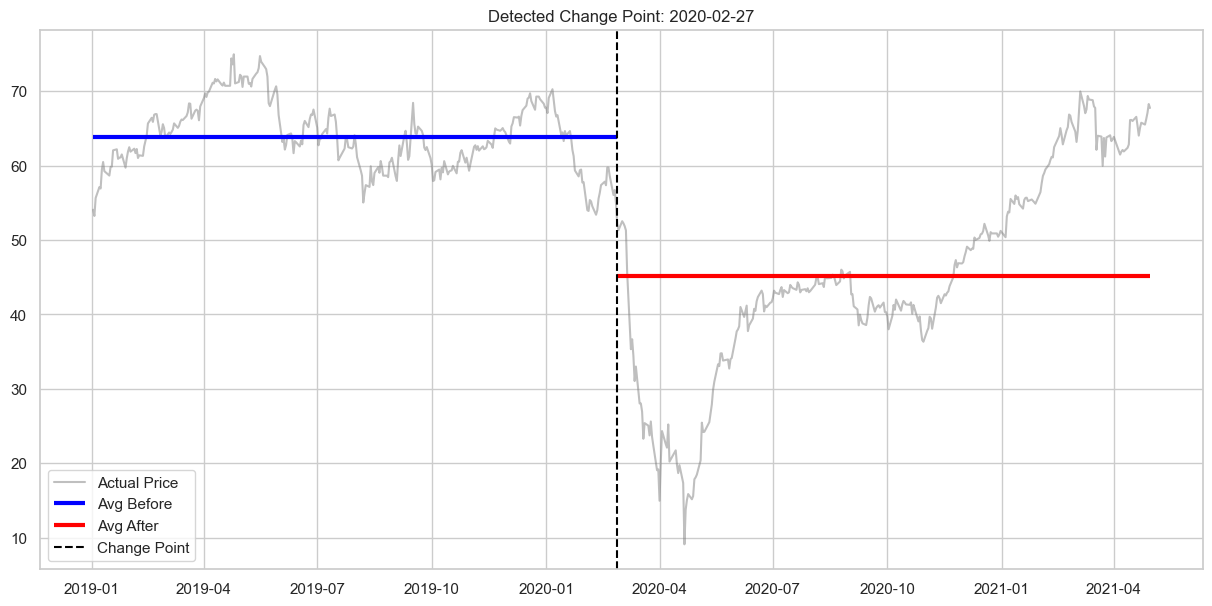

Results saved to data/model_results.json


In [6]:
# Cell 5: Visualize and Save
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(df_window.index, df_window['Price'], label='Actual Price', color='gray', alpha=0.5)
ax.hlines(mu_1_mean, df_window.index[0], detected_date, colors='blue', lw=3, label='Avg Before')
ax.hlines(mu_2_mean, detected_date, df_window.index[-1], colors='red', lw=3, label='Avg After')
ax.axvline(detected_date, color='black', linestyle='--', label='Change Point')
plt.legend()
plt.title(f"Detected Change Point: {date_str}")
plt.savefig('../reports/change_point_plot.png') # Save plot for report
plt.show()

# SAVE RESULTS TO JSON (For the Dashboard)
results = {
    "detected_date": date_str,
    "price_before": mu_1_mean,
    "price_after": mu_2_mean,
    "percent_change": pct_change,
    "period_start": start_date,
    "period_end": end_date
}

with open('../data/model_results.json', 'w') as f:
    json.dump(results, f)
    print("Results saved to data/model_results.json")